# Cell 1 - Import & Loading

In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from langdetect import detect, LangDetectException

import umap
import hdbscan

DATA_PROCESSED_DIR = os.path.join("..", "data", "processed")
print("DATA_PROCESSED_DIR:", DATA_PROCESSED_DIR)


DATA_PROCESSED_DIR: ../data/processed


In [4]:
data_path = os.path.join(DATA_PROCESSED_DIR, "spotify_dataset_clean.csv")  # cambia nome se diverso
df = pd.read_csv(data_path)

print("Shape df:", df.shape)
df.head()

Shape df: (169909, 15)


,track_id,track_name,artist_name,popularity,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms
0,6KbQ3uYMLKb5jDxLF7wYDD,Singende Bataillone 1. Teil,['Carl Woitschach'],0,1928,0.995,0.708,0.1950,0.563,0.1510,-12.428,0.0506,118.469,0.7790,158648
1,6KuQTIu1KoTTkLXKrwlLPV,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",0,1928,0.994,0.379,0.0135,0.901,0.0763,-28.454,0.0462,83.972,0.0767,282133
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],0,1928,0.604,0.749,0.2200,0.000,0.1190,-19.924,0.9290,107.177,0.8800,104300
3,6M94FkXd15sOAOQYRnWPN8,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],0,1928,0.995,0.781,0.1300,0.887,0.1110,-14.734,0.0926,108.003,0.7200,180760
4,6N6tiFZ9vLTSOIxkj8qKrd,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",1,1928,0.990,0.210,0.2040,0.908,0.0980,-16.829,0.0424,62.149,0.0693,687733


# Cell 2 - Audio features selection

In [5]:
feature_cols = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "liveness",
    "loudness",
    "speechiness",
    "tempo",
    "valence",
    "duration_ms"
]

missing = [c for c in feature_cols if c not in df.columns]
print("Feature mancanti:", missing)


Feature mancanti: []


# Cell 3 - Rows cleaning & scaling

In [6]:
# Righe valide per il clustering
df_feat = df.dropna(subset=feature_cols).copy()
print("Righe valide per clustering:", df_feat.shape)

# Standardizzazione delle feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_feat[feature_cols])

X_scaled.shape

Righe valide per clustering: (169909, 15)


(169909, 10)

# Cell 4 - UMAP 10D for clustering & UMAP 2D for graphs

In [8]:
# UMAP 10D per clustering
umap_10 = umap.UMAP(
    n_components=10,
    n_neighbors=50,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)
X_umap_10 = umap_10.fit_transform(X_scaled)
print("UMAP 10D shape:", X_umap_10.shape)

# UMAP 2D per visualizzazione
umap_2 = umap.UMAP(
    n_components=2,
    n_neighbors=50,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)
X_umap_2d = umap_2.fit_transform(X_scaled)
print("UMAP 2D shape:", X_umap_2d.shape)


/Users/Vitaliano/Desktop/Data Science/FDS - Fundamentals of Data Science/Homework di Gruppo/Final Project/Music-mood pred/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/Vitaliano/Desktop/Data Science/FDS - Fundamentals of Data Science/Homework di Gruppo/Final Project/Music-mood pred/.venv/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP 10D shape: (169909, 10)


/Users/Vitaliano/Desktop/Data Science/FDS - Fundamentals of Data Science/Homework di Gruppo/Final Project/Music-mood pred/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP 2D shape: (169909, 2)


# Cell 5 - HDBSCAN on UMAP-10D's space -> Macro-clusters

In [36]:
n_samples = X_umap_10.shape[0]
print("Numero di campioni:", n_samples)

# Parametri HDBSCAN (macro-cluster robusti)
min_cluster_size = max(30, n_samples // 400)   # ~0.25% del dataset, minimo 30
min_samples = max(10, min_cluster_size // 2)

print("Parametri HDBSCAN:")
print("  min_cluster_size:", min_cluster_size)
print("  min_samples:", min_samples)

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

macro_labels = clusterer.fit_predict(X_umap_10)

df_feat["macro_cluster"] = macro_labels
df_feat["is_noise"] = (macro_labels == -1)

cluster_counts = df_feat["macro_cluster"].value_counts().sort_index()
print("Macro-cluster counts (incluso -1 = rumore):")
print(cluster_counts)

# Silhouette solo sui punti non-rumore
mask_core = df_feat["macro_cluster"] >= 0
labels_core = df_feat.loc[mask_core, "macro_cluster"].values

if len(np.unique(labels_core)) >= 2 and mask_core.sum() > 100:
    sil = silhouette_score(X_umap_10[mask_core], labels_core)
    print(f"\nSilhouette score (solo macro-cluster non-rumore): {sil:.4f}")
else:
    print("\nSilhouette score non calcolabile (troppi pochi cluster o punti).")

Numero di campioni: 169909
Parametri HDBSCAN:
  min_cluster_size: 424
  min_samples: 212


/Users/Vitaliano/Desktop/Data Science/FDS - Fundamentals of Data Science/Homework di Gruppo/Final Project/Music-mood pred/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/Vitaliano/Desktop/Data Science/FDS - Fundamentals of Data Science/Homework di Gruppo/Final Project/Music-mood pred/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Macro-cluster counts (incluso -1 = rumore):
macro_cluster
0      3874
1     33322
2    132713
Name: count, dtype: int64

Silhouette score (solo macro-cluster non-rumore): 0.4830


# Cell 6 - Graph for Macro-cluster dimension

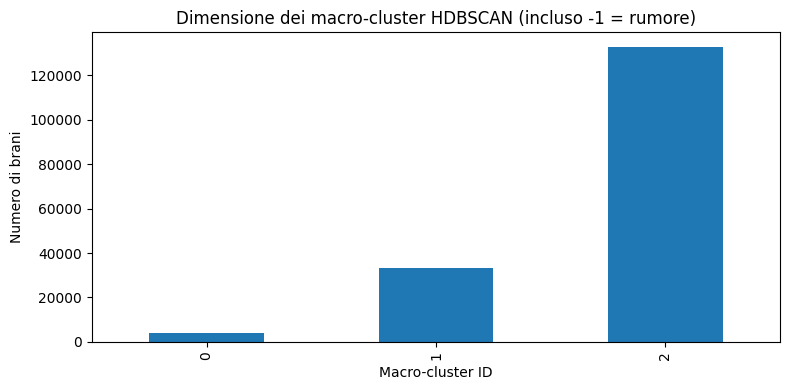

In [10]:
plt.figure(figsize=(8,4))
cluster_counts.plot(kind="bar")
plt.title("Dimensione dei macro-cluster HDBSCAN (incluso -1 = rumore)")
plt.xlabel("Macro-cluster ID")
plt.ylabel("Numero di brani")
plt.tight_layout()
plt.show()

# Cell 8 - UMAP 2D with macro-clusters colorized

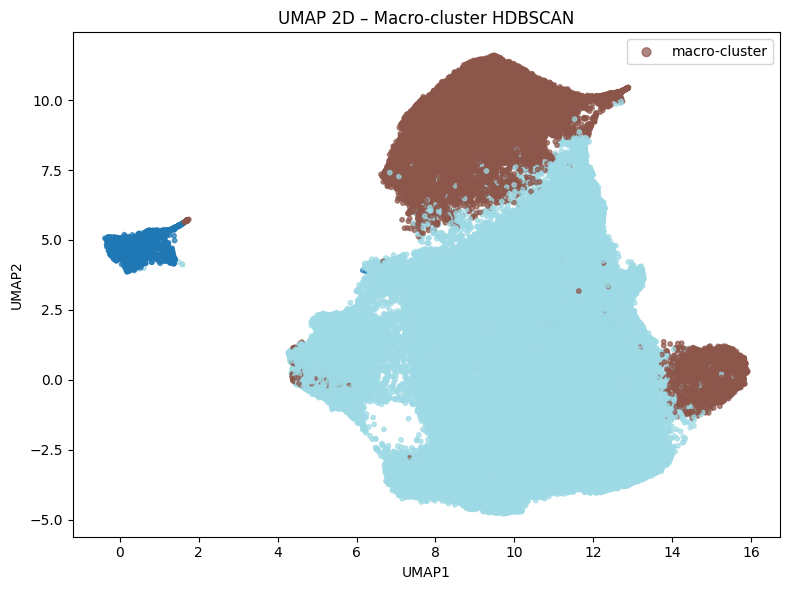

In [11]:
plt.figure(figsize=(8,6))

mask_noise = df_feat["macro_cluster"] == -1
mask_cluster = ~mask_noise

# Punti assegnati a cluster
plt.scatter(
    X_umap_2d[mask_cluster, 0],
    X_umap_2d[mask_cluster, 1],
    c=df_feat.loc[mask_cluster, "macro_cluster"],
    cmap="tab20",
    s=10,
    alpha=0.7,
    label="macro-cluster"
)

# Eventuale rumore
if mask_noise.any():
    plt.scatter(
        X_umap_2d[mask_noise, 0],
        X_umap_2d[mask_noise, 1],
        c="lightgray",
        s=5,
        alpha=0.5,
        label="rumore (-1)"
    )

plt.title("UMAP 2D – Macro-cluster HDBSCAN")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(markerscale=2)
plt.tight_layout()
plt.show()

# Cell 9 - Summary for the macro-cluster's label identification

In [12]:
valid_macro = df_feat["macro_cluster"] >= 0

macro_summary = (
    df_feat[valid_macro]
    .groupby("macro_cluster")[feature_cols]
    .mean()
    .sort_index()
)

macro_summary

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms
macro_cluster,,,,,,,,,,
0,0.467771,0.671075,0.255682,0.005130,0.330862,-18.688232,0.914860,107.482467,0.544188,182201.386680
1,0.735556,0.446669,0.341613,0.753473,0.186519,-15.758386,0.060830,110.361992,0.437490,259120.212862
2,0.433109,0.557239,0.532296,0.017990,0.208130,-10.054895,0.078441,118.877964,0.555496,225883.953795


# Cell 10 - Features' heatmap per macro-cluster

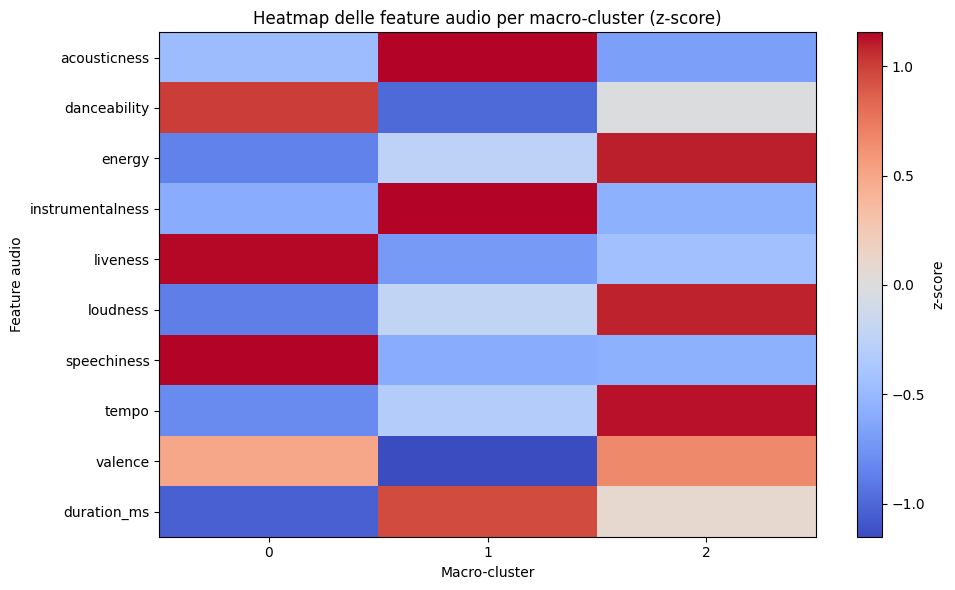

In [13]:
macro_summary_norm = (
    (macro_summary - macro_summary.mean()) / macro_summary.std()
)

plt.figure(figsize=(10,6))
im = plt.imshow(macro_summary_norm.T, aspect="auto", cmap="coolwarm")

plt.colorbar(im, label="z-score")

plt.yticks(
    ticks=range(len(macro_summary_norm.columns)),
    labels=macro_summary_norm.columns
)
plt.xticks(
    ticks=range(len(macro_summary_norm.index)),
    labels=macro_summary_norm.index
)

plt.title("Heatmap delle feature audio per macro-cluster (z-score)")
plt.xlabel("Macro-cluster")
plt.ylabel("Feature audio")
plt.tight_layout()
plt.show()


# Cell 11 - Gerarchic subclustering (K-means for every macro-cluster)

In [45]:
df_feat["subcluster"] = None  # conterrà stringhe tipo "0_0", "0_1", "1_0", ...

unique_macro = sorted([c for c in df_feat["macro_cluster"].unique() if c >= 0])
print("Macro-cluster su cui facciamo subclustering:", unique_macro)

subcluster_ids = []

for c in unique_macro:
    mask_c = df_feat["macro_cluster"] == c
    X_c = X_umap_10[mask_c]
    n_c = X_c.shape[0]
    print(f"\nMacro-cluster {c}: {n_c} brani")

    if n_c < 100:
        print("  Troppo pochi brani, salto il subclustering.")
        continue

    # Heuristica per numero di subcluster dentro c
    if n_c < 5000:
        k_c = 2
    elif n_c < 35000:
        k_c = 3
    else:
        k_c = 6

    print(f"  Uso KMeans con k = {k_c} subcluster")

    kmeans_c = KMeans(
        n_clusters=k_c,
        random_state=42,
        n_init=20
    )
    labels_c = kmeans_c.fit_predict(X_c)

    # Codifichiamo i subcluster come "macro_sub" (stringa)
    global_ids = [f"{c}_{l}" for l in labels_c]
    df_feat.loc[mask_c, "subcluster"] = global_ids

    subcluster_ids.extend(sorted(set(global_ids)))

print("\nSubcluster globali creati:", sorted(set(subcluster_ids)))


Macro-cluster su cui facciamo subclustering: [0, 1, 2]

Macro-cluster 0: 3874 brani
  Uso KMeans con k = 2 subcluster

Macro-cluster 1: 33322 brani
  Uso KMeans con k = 3 subcluster

Macro-cluster 2: 132713 brani
  Uso KMeans con k = 6 subcluster

Subcluster globali creati: ['0_0', '0_1', '1_0', '1_1', '1_2', '2_0', '2_1', '2_2', '2_3', '2_4', '2_5']


# Cell 12 - Summary for sub-clusters

In [46]:
df_sub = df_feat[df_feat["subcluster"].notna()].copy()

subcluster_summary = (
    df_sub
    .groupby("subcluster")[feature_cols]
    .mean()
    .sort_index()
)

subcluster_summary

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms
subcluster,,,,,,,,,,
0_0,0.344141,0.691918,0.204780,0.002379,0.277800,-19.246449,0.917158,110.219996,0.570965,112354.240712
0_1,0.715414,0.629323,0.357644,0.010642,0.437151,-17.570067,0.910255,101.998922,0.490550,322112.258915
1_0,0.905267,0.308582,0.156997,0.800893,0.167886,-20.604054,0.048183,96.757403,0.178934,326022.307802
1_1,0.901308,0.543354,0.330438,0.747177,0.200970,-14.205328,0.075352,117.093294,0.641392,187394.628187
1_2,0.123278,0.531765,0.705924,0.676251,0.195493,-9.490165,0.058513,123.730674,0.556025,262283.212502
2_0,0.792156,0.621782,0.371402,0.019055,0.183122,-11.839087,0.089119,113.027914,0.713708,174914.838836
2_1,0.083177,0.492249,0.787981,0.016737,0.192637,-6.457206,0.082502,139.656684,0.500578,235073.009545
2_2,0.198152,0.710862,0.667548,0.009845,0.150888,-8.080735,0.098609,111.176443,0.731952,228046.093476
2_3,0.866599,0.406124,0.196410,0.024760,0.163935,-15.543252,0.044752,96.954149,0.285893,209920.065722


# Cell 13 - Subclusters heatmap

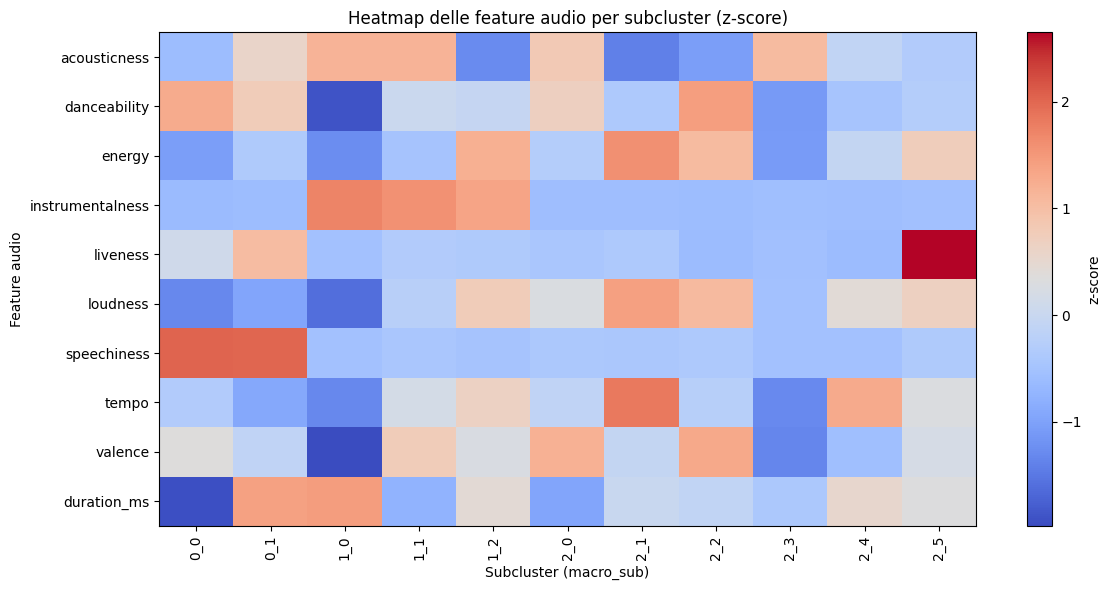

In [47]:
subcluster_summary_norm = (
    (subcluster_summary - subcluster_summary.mean()) / subcluster_summary.std()
)

plt.figure(figsize=(12,6))
im = plt.imshow(subcluster_summary_norm.T, aspect="auto", cmap="coolwarm")

plt.colorbar(im, label="z-score")

plt.yticks(
    ticks=range(len(subcluster_summary_norm.columns)),
    labels=subcluster_summary_norm.columns
)
plt.xticks(
    ticks=range(len(subcluster_summary_norm.index)),
    labels=subcluster_summary_norm.index,
    rotation=90
)

plt.title("Heatmap delle feature audio per subcluster (z-score)")
plt.xlabel("Subcluster (macro_sub)")
plt.ylabel("Feature audio")
plt.tight_layout()
plt.show()

# Cell 14 - UMAP 2D with colorized subclusters

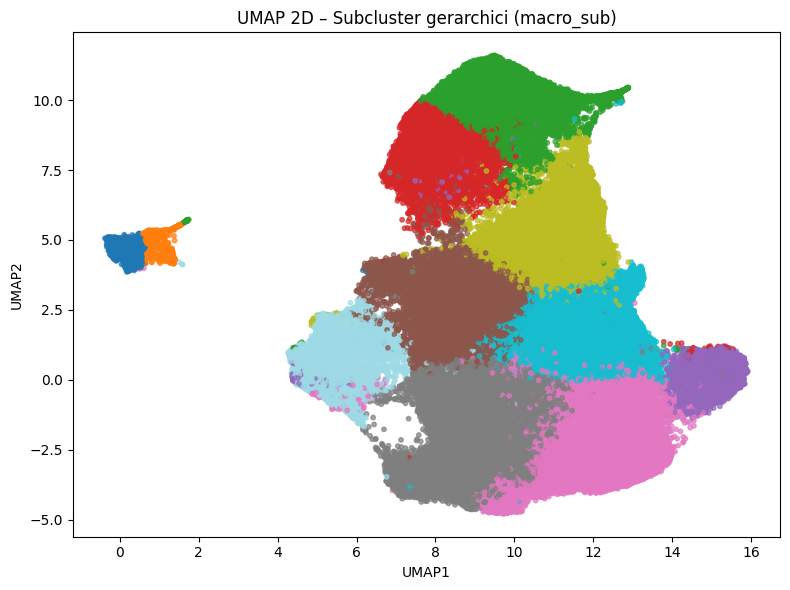

In [48]:
plt.figure(figsize=(8,6))

mask_sub = df_feat["subcluster"].notna()
sub_ids = df_feat.loc[mask_sub, "subcluster"]

# Mappiamo ogni subcluster stringa in un intero per il colore
sub_unique = sorted(sub_ids.unique())
sub_to_int = {s: i for i, s in enumerate(sub_unique)}
sub_int = sub_ids.map(sub_to_int).values

plt.scatter(
    X_umap_2d[mask_sub, 0],
    X_umap_2d[mask_sub, 1],
    c=sub_int,
    cmap="tab20",
    s=10,
    alpha=0.7
)

plt.title("UMAP 2D – Subcluster gerarchici (macro_sub)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()


#  Cell 15 - Subclusters labeling

In [ ]:
df_clustered = df.copy()

df_clustered = df_clustered.join(
    df_feat[["macro_cluster", "subcluster"]],
    how="left"
)
# === Dizionario di etichette interpretative per ciascun subcluster ===

SUBCLUSTER_LABELS = {
    # Macro 0 – spoken moods
    "0_0": "Short Spoken Calm",
    "0_1": "Long Spoken Emotional",

    # Macro 1 – calm ↔ epic moods
    "1_0": "Deep Calm & Minimal",
    "1_1": "Warm Emotional Calm",
    "1_2": "Epic Intense",

    # Macro 2 – pop/electronic mood spectrum
    "2_0": "Uplifting Gentle",
    "2_1": "Intense High-Energy",
    "2_2": "Happy Energetic",
    "2_3": "Soft Sad Calm",
    "2_4": "Balanced Upbeat",
    "2_5": "Energetic Live Mood"
}

df_clustered["subcluster_label"] = df_clustered["subcluster"].map(SUBCLUSTER_LABELS)
print("✔ Mood labels assegnate.")


✔ Mood labels assegnate.


# Cell 16 - Finding problematic song's genre

In [52]:
def contains_any(s, patterns):
    """
    Ritorna una Series booleana: True se la stringa contiene almeno
    una delle parole nella lista patterns (case insensitive).
    """
    if not isinstance(patterns, (list, tuple)):
        patterns = [patterns]

    # normalizza: minuscolo e sostituisci NaN con stringa vuota
    s_norm = s.fillna("").astype(str).str.lower()
    # costruiamo una regex "pattern1|pattern2|..."
    regex = "|".join(patterns)
    return s_norm.str.contains(regex, regex=True, na=False)


In [53]:
# --- Flag di contenuto "critico" / speciale --- 
# (ORA controlliamo SOLO il titolo della canzone: track_name)

kids_patterns = [
    "kids", "children", "nursery", "baby", "bimbi", "bambini",
    "lullaby", "ninna nanna", "ninna-nanna", "canzoni per bambini",
    "disney", "cartoon", "cartoons"
]

xmas_patterns = [
    "christmas", "xmas", "natale", "noel", "navidad",
    "feliz navidad", "silent night", "jingle bells", "we wish you a merry christmas"
]

nursery_patterns = [
    "nursery", "lullaby", "ninna nanna", "ninna-nanna"
]

religious_patterns = [
    "gospel", "worship", "hallelujah", "mass", "messe", "messa",
    "kirche", "church", "santo", "gloria", "allelui(a|ah)"
]


def flag_in_track_name(df_local, patterns):
    """
    Cerca pattern SOLO in track_name. Ritorna una Series booleana.
    """
    if "track_name" not in df_local.columns:
        return pd.Series(False, index=df_local.index)

    return contains_any(df_local["track_name"], patterns)


# Applichiamo i flag a df_clustered usando SOLO il titolo della canzone
df_clustered["is_kids"] = flag_in_track_name(df_clustered, kids_patterns)
df_clustered["is_christmas"] = flag_in_track_name(df_clustered, xmas_patterns)
df_clustered["is_nursery"] = flag_in_track_name(df_clustered, nursery_patterns)
df_clustered["is_religious"] = flag_in_track_name(df_clustered, religious_patterns)

print("Flag contenuto aggiunti:")
print(df_clustered[["is_kids", "is_christmas", "is_nursery", "is_religious"]].sum())


Flag contenuto aggiunti:
is_kids         1663
is_christmas     387
is_nursery       163
is_religious     410
dtype: int64


/var/folders/zx/yp44pnk179bb5pqlljkjxp0m0000gp/T/ipykernel_98383/3926096845.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  return s_norm.str.contains(regex, regex=True, na=False)


# Cell 17 - Language detectiom

In [50]:
# ============================
#  LANGUAGE DETECTION (track language)
# ============================
def detect_language_for_row(row):
    """
    Usa il testo disponibile (track_name + artist_name) per stimare la lingua.
    Restituisce un codice ISO2 tipo 'en', 'it', 'es', ... oppure 'unknown'.
    """
    parts = []

    if "track_name" in row and isinstance(row["track_name"], str):
        parts.append(row["track_name"])
    if "artist_name" in row and isinstance(row["artist_name"], str):
        parts.append(row["artist_name"])

    text = " ".join(parts).strip()
    if not text:
        return "unknown"

    try:
        code = detect(text)   # es. 'en', 'it', 'es', ...
        return code.lower()
    except LangDetectException:
        return "unknown"
    except Exception:
        return "unknown"

print("→ Detecting language for each track (può richiedere un po' di tempo)...")

df_clustered["language_raw"] = df_clustered.apply(detect_language_for_row, axis=1)

# Normalizziamo in un set di lingue principali che useremo nel recommender
MAIN_LANGS = {"en", "it", "es", "fr", "de", "pt"}

def normalize_language(code):
    code = str(code).lower()
    if code in MAIN_LANGS:
        return code
    elif code in ("unknown", "", "none", "nan"):
        return "other"
    else:
        # tutte le altre lingue compattate in 'other'
        return "other"

df_clustered["main_language"] = df_clustered["language_raw"].apply(normalize_language)

print("Distribuzione 'main_language':")
print(df_clustered["main_language"].value_counts(dropna=False))

→ Detecting language for each track (può richiedere un po' di tempo)...
Distribuzione 'main_language':
main_language
en       108396
other     26107
de        12125
es        10638
it         4890
pt         3915
fr         3838
Name: count, dtype: int64


# Cell 18 - Saving clustered dataset

In [51]:

print("Shape df_clustered:", df_clustered.shape)
df_clustered[["macro_cluster", "subcluster"]].head()
out_path = os.path.join(DATA_PROCESSED_DIR, "spotify_dataset_clustered.csv")
df_clustered.to_csv(out_path, index=False)
print("Salvato:", out_path)

Shape df_clustered: (169909, 24)
Salvato: ../data/processed/spotify_dataset_clustered.csv
